# Windspeed Analysis for Windfarm
***


Ireland’s abundant wind resources make it an ideal candidate for harnessing wind energy, a key component in the country’s transition to renewable energy. This project focuses on analyzing wind speed data from a specific location in Ireland,  utilizing historical weather data from Met Éireann. By examining trends and patterns in hourly collected wind speed data over different timeframes — this analysis aims to assess the potential for wind energy generation near Mace Head in Galway. Additionally, it considers operational factors, such as the minimum and maximum wind speeds at which wind turbines operate, to evaluate the feasibility and efficiency of wind farm operations.

The analysis also delves into long-term trends in wind speeds to assess whether they are consistent or show significant changes over the decades, providing insights into future wind energy potential. Beyond wind speed, other weather metric such as temperature will be explored to understand its impact on wind farm efficiency. This project will also explore the challenges of forecasting wind power output by leveraging available weather predictions and wind turbine power curves. Ultimately, the findings will provide actionable insights for optimizing wind farm development and contribute to Ireland’s renewable energy goals.

For this project the county of Galway and more specific the Met Eireann station in Mace Head was chosen to have the wind speed analysed for windfarm.

## Read in and clean the data

In [840]:
# Import modules

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from matplotlib.lines import Line2D

import seaborn as sns

import calendar

from sklearn.linear_model import LinearRegression

import scipy.stats as stats

import statsmodels.api as sm

The file hly275.csv downloaded from [Met Eireann website](https://www.met.ie/climate/available-data/historical-data) has some rows that need to be removed to allow proper analysis of the data [[58]](58).

In [841]:
# Read in Data and skip first 17 rows 

file = 'hly275.csv'

df = pd.read_csv(file,skiprows=17,low_memory=False)

In [842]:
# Quick look into the first 5 rows
df.head(5)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,13-aug-2003 01:00,-1,,4,,4,,,,,,7,,7,
1,13-aug-2003 02:00,-1,,4,,4,,,,,,7,,7,
2,13-aug-2003 03:00,-1,,4,,4,,,,,,7,,7,
3,13-aug-2003 04:00,-1,,4,,4,,,,,,7,,7,
4,13-aug-2003 05:00,-1,,4,,4,,,,,,7,,7,


The first 5 rows show a lot of null data in column wdsp (mean windspeed). Therefore let's have a look at the number of 'NaN' values in this dataset.

In [843]:
# Confirming the count of Non-null data and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186744 entries, 0 to 186743
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    186744 non-null  object
 1   ind     186744 non-null  int64 
 2   rain    186744 non-null  object
 3   ind.1   186744 non-null  int64 
 4   temp    186744 non-null  object
 5   ind.2   186744 non-null  int64 
 6   wetb    186744 non-null  object
 7   dewpt   186744 non-null  object
 8   vappr   186744 non-null  object
 9   rhum    186744 non-null  object
 10  msl     186744 non-null  object
 11  ind.3   186744 non-null  int64 
 12  wdsp    186744 non-null  object
 13  ind.4   186744 non-null  int64 
 14  wddir   186744 non-null  object
dtypes: int64(5), object(10)
memory usage: 21.4+ MB


From `df.info()` output was no appearant null data. This goes against what we have just seen in the first 5 rows output from `df.head()` and that might be due to the data type. Therefore let's check the number of unique values in 'wdsp' column.

In [844]:
# See all unique values in the column 'wdsp'
print(df['wdsp'].unique())  

[' ' '6' '4' '3' '5' '7' '9' '12' '10' '8' '2' '1' '11' '13' '16' '17'
 '19' '22' '25' '23' '14' '18' '20' '21' '15' '24' '26' '30' '28' '29'
 '27' '33' '36' '31' '32' '34' '37' '42' '44' '40' '35' '38' '39' '41'
 '43' '53' '50' '48' '47' '46' '0' '45' '51' '52' '49' '56' '55' '54']


From the output of unique values function we found that the data type in column 'wdsp' is mixed, showing string and numeric data types. Also, there is null data, so let's clean the data.

### Replace null values and Dropna

In [845]:
# Replace non-numeric or invalid values with NaN
df['wdsp'] = df['wdsp'].replace([' ', '', 'NA', 'null'], np.nan)

In [846]:
# Count NaN values in 'wdsp'
nan_wdsp_count = df['wdsp'].isnull().sum()

# Verify number of NaN values
print(f"Number of NaN values in 'wdsp': {nan_wdsp_count}")

Number of NaN values in 'wdsp': 1296


In [847]:
# Drop rows where 'wdsp' is NaN
df = df.dropna(subset=['wdsp'])

# Verify if NaN values are removed
null_wdsp_count = df['wdsp'].isna().sum()
print(f"Number of NaN values in 'wdsp' after dropping: {null_wdsp_count}")

Number of NaN values in 'wdsp' after dropping: 0


### Change data type for column 'wdsp'

In [848]:
# Convert 'wdsp' to integer, coercing non-convertible values to NaN
df['wdsp'] = pd.to_numeric(df['wdsp']).astype('Int64') 

# Verify the data types
print(df['wdsp'].dtypes)

Int64


### Normalise datetime

In [849]:
# Check the first few rows for 'date' column
print(df['date'].head(5))

24    14-aug-2003 01:00
25    14-aug-2003 02:00
26    14-aug-2003 03:00
27    14-aug-2003 04:00
28    14-aug-2003 05:00
Name: date, dtype: object


In [850]:
# Change date time format
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

# Confirm the new date time format
df['date']

24       2003-08-14 01:00:00
25       2003-08-14 02:00:00
26       2003-08-14 03:00:00
27       2003-08-14 04:00:00
28       2003-08-14 05:00:00
                 ...        
186739   2024-11-30 20:00:00
186740   2024-11-30 21:00:00
186741   2024-11-30 22:00:00
186742   2024-11-30 23:00:00
186743   2024-12-01 00:00:00
Name: date, Length: 185448, dtype: datetime64[ns]

## Wind power in Mace Head - Galway

To determine the wind power available in Mace Head the variability of wind speeds and the operational characteristics of wind turbines are taken into consideration.

For this project hourly mean wind speeds will be used as they preserve much of the variability.

The wind power is calculated as per formula below [[59]](59):

$P = 0.5 C_p \rho \pi R^2 V^3$

where:
- $Cp$ is the coefficient of performance (efficiency factor, $\%$)
- $ρ$ is air density ($kg/m3$)
- $R$ is the radius of the wind turbine ($m$)
- $V$ is the wind speed ($m/s$).


### Turbine Operational Ranges

In County Galway, Vestas V52 is the most commonly used turbine in wind farms, accounting for 70 out of 192 turbines currently confirmed as operational [[60]](60). In the table below is possible to see the specification for this turbine model [[61]](61).

| **Wind Turbine Model**     | **Cut-in Wind Speed** | **Rated Wind Speed** | **Cut-out Wind Speed** | **Rated Power** | **Efficiency** | **Rotor Diameter** |
|----------------------------|-----------------------|----------------------|------------------------|----------------|----------------|--------------------|
| **Vestas V52**              | 4.0 m/s               | 14 m/s               | 25.0 m/s               | 0.85 MW        | 45%            | 52.0 m            |

### Wind Power Calculation for Vestas V52

To calculate the power output of a wind turbine like the Vestas V52 considering its operational wind speed range (cut-in, rated, and cut-out wind speeds), the formula can be divided into four distinct regions [[62]](62):

1. Below Cut-in Wind Speed:    
$V < V_{cut-in}$.   
The turbine produces no power:    
$P = 0$

2. Between Cut-in and Rated Wind Speed:   
$V_{\text{cut-in}} \leq V < V_{\text{rated}}$    
The power output increases with the cube of the wind speed:   
$P = 0.5 C_p \rho \pi R^2 V^3$.     

3. Between Rated and Cut-out Wind Speed:   
$V_{\text{rated}} \leq V < V_{\text{cut-out}}$  
The turbine operates at constant rated power:    
$P = P_{\text{rated}}$  

4. Above Cut-out Wind Speed:   
$V \geq V_{\text{cut-out}}$  
The turbine is shut down for safety, and the power is:  
$P = 0$

Using these regions, we can calculate the turbine's output for a specific wind speed V.
From Vestas V52 turbine specification we have:

In [851]:
# Vestas V52 Specification
speed_cut_in = 4.0  # m/s
speed_rated = 14.0  # m/s
speed_cut_out = 25.0  # m/s
power_rated = 0.85 * 10**6  # Watts (MW converted to Watts)
efficiency = 0.45 # coefficient of performance
rotor_diameter = 52.0 # m

Air density is also required for the wind power calculation. The air density is a standard value [[63]](63):

$ρ = 1.225 kg/m^3$  

Therefore, this is also added to the script:

In [852]:
# Air Density
air_density = 1.225  # kg/m³ (standard)

The wind speed in column 'wdsp' of the dataset is given in $knot$ and needs to be converted to $m/s$ [[64]](64):

$1 knot = 0.514 m/s$

Let's create a column in the data frame with the converted value.

In [853]:
# Convert knots to m/s
knot_to_ms = 0.51444  # m/s

# Create column in df with unit in m/s
df['wdsp_ms'] = df['wdsp'] * knot_to_ms

# Confirming the first 5 rows of this new column
df['wdsp_ms'].head()

24    3.08664
25    2.05776
26    1.54332
27     2.5722
28    3.08664
Name: wdsp_ms, dtype: Float64

The rotor is giving in diameter and this needs to be changed to radius [[65]](65). To do that we use the formula:

$r = \frac{d}{2}$

And then we also calculate the rotor area which is part of the region 2 of the formula.

In [854]:
# Convert diameter to radius
rotor_radius = rotor_diameter / 2

print (f'The rotor radius is {rotor_radius} m')

# Calculate the rotor area
rotor_area = np.pi * (rotor_radius ** 2)

print(f'The rotor area is {rotor_area:.2f} m²')

The rotor radius is 26.0 m
The rotor area is 2123.72 m²


With all the constants values determined we can now define the function to calculate wind power based on wind speed:

In [855]:
# Function to calculate power
def calculate_wind_power(wind_speed):
    if wind_speed < speed_cut_in or wind_speed > speed_cut_out:
        return 0
    elif wind_speed < speed_rated:
        rotor_area = np.pi * (40 ** 2)
        return 0.5 * air_density * rotor_area * (wind_speed ** 3) * efficiency
    else:
        return power_rated

Next, we use the function to create a column in the data frame called 'wdpr' (Wind Power) which is given in Watts:

In [856]:
# Create column wdpr
df['wdpr'] = df['wdsp_ms'].apply(calculate_wind_power)

With the Wind Power column added to the dataset now we can calculate the following:

- Total Power. 
- The mean wind power per hour.

Note: This is the total power and average power per hour that could have been generated since the station started collecting the wind speed data (13-aug-2003). This is hypotethical scenario and does not take into consideration the variability of the wind speed within the hour since is using the mean wind speed per hour.

In [857]:
# Mean power in Watts
mean_power = df['wdpr'].mean()  

# Convert Watts to MW for reporting
mean_power_mw = mean_power / 10**6

# Calculate expected annual production in MWh
hours_per_year = 365 * 24  # Total hours in a year
annual_production_mwh = mean_power_mw * hours_per_year  # In MWh

# Convert annual production to GWh
annual_production_gwh = annual_production_mwh / 1000  # In GWh

# Print results
print(f"Mean wind power: {mean_power_mw:.2f} MW/h")
print(f"Expected annual wind power production: {annual_production_gwh:.2f} GW")

Mean wind power: 0.76 MW/h
Expected annual wind power production: 6.63 GW


From this analysis the findings show that each turbine from the model Vestas V52 can produce a mean wind power of 0.76 MW/h near Mace Head, and that's expected to produce about 6.63 GW within a full year of operation.

### Expected variation of generated power 

Further, we analyze wind power availability across different times of the day and year.

#### Analysis of the windspeed per hour of the day

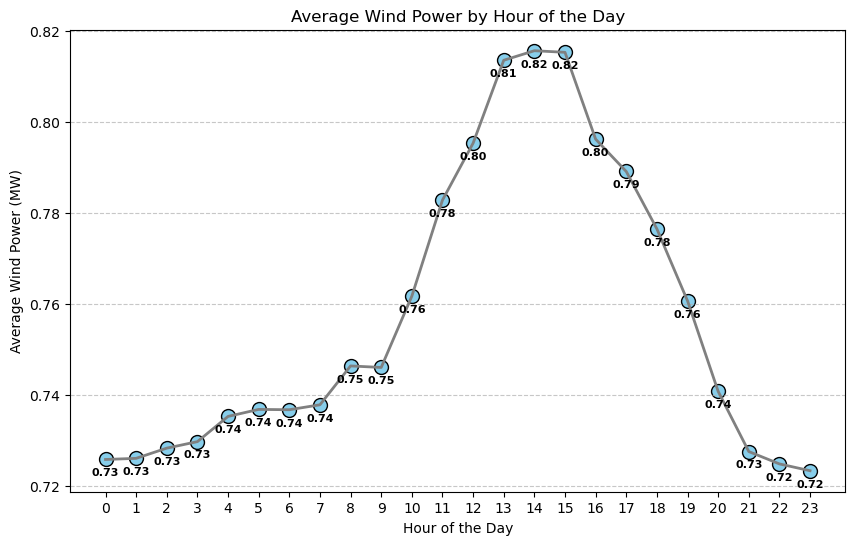

In [892]:
# Extract hour from the 'date' column
df['hour'] = df['date'].dt.hour

# Calculate average wind power for each hour of the day
hourly_power = df.groupby('hour')['wdpr'].mean()

# Convert to MW for better readability
hourly_power_mw = hourly_power / 10**6

# Set up figsize
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(hourly_power_mw.index, hourly_power_mw.values, color='skyblue', edgecolor='black', s=100)

# Line plot connecting the points
plt.plot(hourly_power_mw.index, hourly_power_mw.values, color='gray', linewidth=2)

# Titles and labels
plt.title('Average Wind Power by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Wind Power (MW)')

# Set x-axis labels to be integers (hour)
plt.xticks(ticks=range(24), labels=[str(i) for i in range(24)], rotation=0)

# Add gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels above each point (shifted higher and bold)
for i in range(len(hourly_power_mw)):
    plt.text(hourly_power_mw.index[i], hourly_power_mw.values[i]-0.004,  # Shifted higher by 0.01
             f'{hourly_power_mw.values[i]:.2f}', ha='center', va='bottom', 
             fontsize=8, fontweight='bold')  # Make the font bold

# Show the plot
plt.show()

#### Analysis of the windspeed per month & season of the year

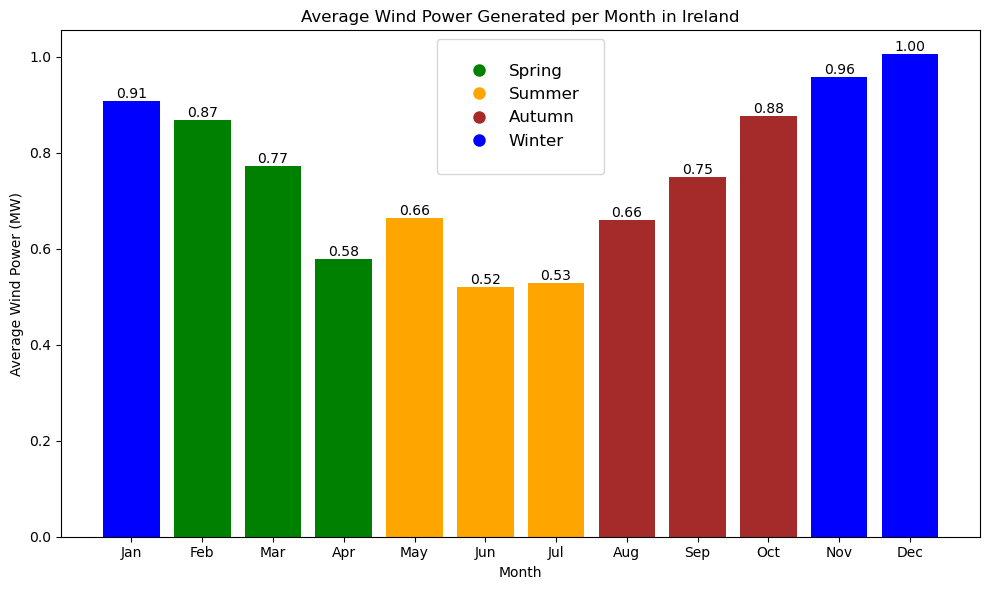

In [ ]:
# Extract month from the 'date' column
df['month'] = df['date'].dt.month

# Define Irish calendar seasons
irish_seasons = {
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn',
    11: 'Winter', 12: 'Winter', 1: 'Winter'
}

# Map months to Irish seasons
df['season'] = df['month'].map(irish_seasons)

# Calculate average wind power for each month
monthly_power = df.groupby('month')['wdpr'].mean()

# Convert to MW
monthly_power_mw = monthly_power / 10**6

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each season
season_colors = {
    'Spring': 'green',
    'Summer': 'orange',
    'Autumn': 'brown',
    'Winter': 'blue'
}

# Plot each month with the corresponding season color
bars = []
for month, power in monthly_power_mw.items():
    season = df.loc[df['month'] == month, 'season'].iloc[0]  # Get season for the month
    bar = ax.bar(month, power, color=season_colors[season])
    bars.append(bar)

    # Add data label above each bar (using the individual bar rectangle)
    for b in bar:
        ax.text(b.get_x() + b.get_width() / 2, b.get_height(), 
                f'{b.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Set axis labels
ax.set_xlabel('Month')
ax.set_ylabel('Average Wind Power (MW)')
ax.set_title('Average Wind Power Generated per Month in Ireland')

# Define custom legend handles for each season
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
                  for color in season_colors.values()]
legend_labels = list(season_colors.keys())

# Create a legend at the top center, with items stacked vertically
ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1, 
          fontsize=12, frameon=True, borderpad=1.5, handlelength=2)

# Set x-axis to show month names
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Display the plot
plt.tight_layout()
plt.show()

### Wind Speed Trend

In [868]:
# Extract the year from the 'Date'
df['year'] = df['date'].dt.year

In [869]:
records_per_year = df.groupby('year')['wdsp'].count()
print(records_per_year)

year
2003    2549
2004    8621
2005    8553
2006    8760
2007    8760
2008    8784
2009    8760
2010    8760
2011    8760
2012    8725
2013    8727
2014    8760
2015    8760
2016    8784
2017    8760
2018    8760
2019    8760
2020    8784
2021    8760
2022    8760
2023    8760
2024    8041
Name: wdsp, dtype: Int64


In [870]:
df = df[~df['year'].isin([2003, 2004])]

In [871]:
df = df[df['year'] != 2024]

In [872]:
# Set 'date' as the index
df.set_index('date', inplace=True)

# Define the full date range with hourly frequency
full_date_range = pd.date_range(start='2005-01-01 00:00:00', end='2023-12-31 23:00:00', freq='h')  # Hourly data


In [873]:
# Reindex the DataFrame to include all hourly timestamps
df = df.reindex(full_date_range)

# Check for missing values (NaNs)
print(df.isna().sum())  # Should show missing 'wdsp' values for the newly added timestamps

ind        299
rain       299
ind.1      299
temp       299
ind.2      299
wetb       299
dewpt      299
vappr      299
rhum       299
msl        299
ind.3      299
wdsp       299
ind.4      299
wddir      299
wdsp_ms    299
wdpr       299
hour       299
month      299
season     299
year       299
dtype: int64


In [874]:
# Interpolate the 'wdsp' column to fill missing values
df['wdsp'] = df['wdsp'].interpolate(method='time')

In [875]:
# Interpolate the 'year' column to fill missing values
df['year'] = df['year'].interpolate(method='time')

In [876]:
df['year'] = df['year'].astype(int)

In [877]:
# Check the number of records per year after interpolation
records_per_year = df.groupby(df['year'])['wdsp'].count()
print(records_per_year)

year
2005    8760
2006    8760
2007    8760
2008    8784
2009    8760
2010    8760
2011    8760
2012    8784
2013    8760
2014    8760
2015    8760
2016    8784
2017    8760
2018    8760
2019    8760
2020    8784
2021    8760
2022    8760
2023    8760
Name: wdsp, dtype: Int64


In [878]:
# Reset the index to bring the 'date' column back
df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

In [879]:
annual_avg_wind_speed = df.groupby('year')['wdsp'].mean()

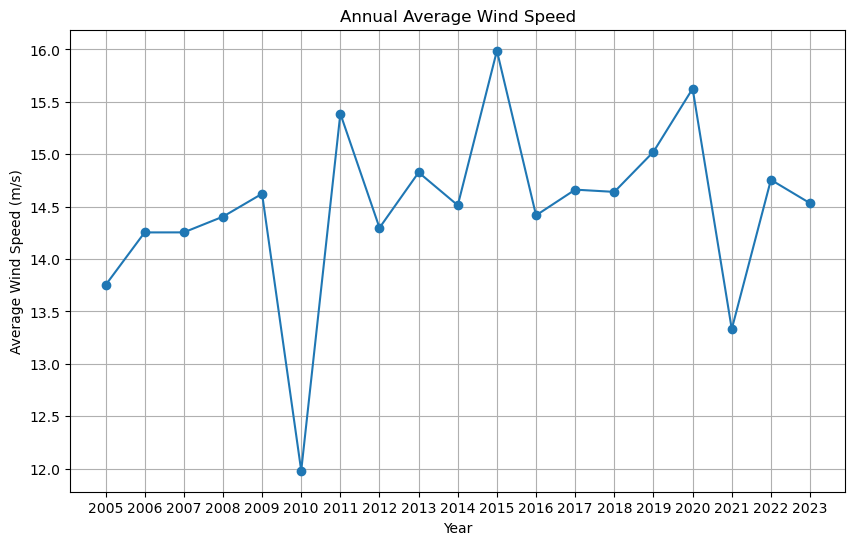

In [880]:
# Calculate annual average wind speed
annual_avg_wind_speed = df.groupby('year')['wdsp'].mean()

# Plot the data
annual_avg_wind_speed.plot(kind='line', marker='o', figsize=(10, 6), title='Annual Average Wind Speed')
plt.xlabel('Year')
plt.ylabel('Average Wind Speed (m/s)')
plt.grid()

# Set the x-axis to display integer years without decimal places
plt.xticks(annual_avg_wind_speed.index)

plt.show()

In [881]:
# Calculate annual average wind speed
annual_avg_wind_speed = df.groupby('year')['wdsp'].mean()

print(annual_avg_wind_speed)

year
2005      13.7504
2006    14.253881
2007    14.254338
2008    14.404258
2009    14.622945
2010    11.979452
2011    15.387443
2012    14.297928
2013    14.826712
2014    14.512671
2015    15.988128
2016    14.416781
2017    14.662215
2018    14.640753
2019    15.023744
2020    15.626138
2021    13.330936
2022     14.75605
2023    14.532534
Name: wdsp, dtype: Float64


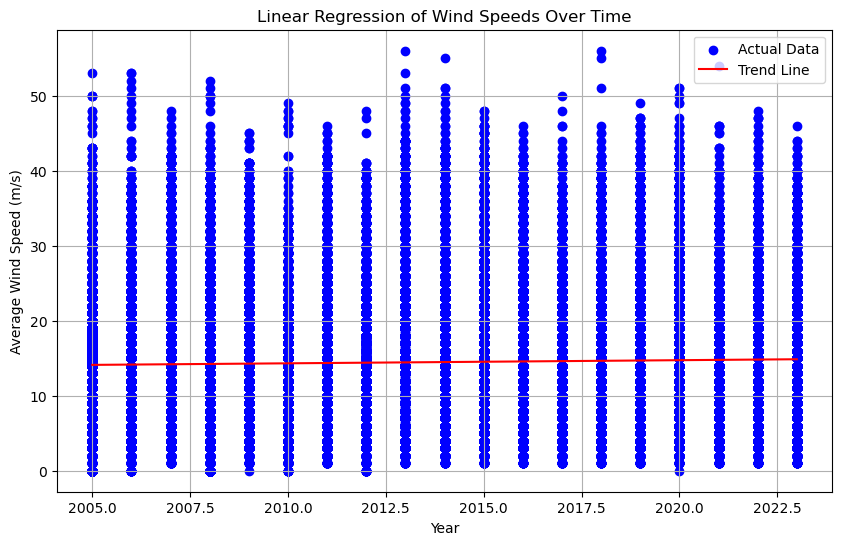

Slope: 0.0418 m/s per year
Intercept: -69.6346
P-value: 0.0000
The p-value is less than 0.05, indicating a statistically significant trend.
The slope of 0.0418 m/s per year means that, on average, wind speed is increasing by 0.0418 meters per second each year.


In [882]:
# Prepare the data for regression
X = df['year']  # Years
y = df['wdsp']  # Average Wind Speed

# Add constant to the independent variable for statsmodels (to include the intercept in the model)
X_with_const = sm.add_constant(X)

# Create the regression model using statsmodels
model = sm.OLS(y, X_with_const)
results = model.fit()

# Get the slope, intercept, and p-value
slope = results.params.iloc[1]
intercept = results.params.iloc[0]
p_value = results.pvalues.iloc[1]

# Make predictions
y_pred = results.predict(X_with_const)

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['year'], df['wdsp'], color='blue', label='Actual Data')
plt.plot(df['year'], y_pred, color='red', label='Trend Line')
plt.title("Linear Regression of Wind Speeds Over Time")
plt.xlabel("Year")
plt.ylabel("Average Wind Speed (m/s)")
plt.legend()
plt.grid(True)
plt.show()

# Print the slope, intercept, and p-value
print(f"Slope: {slope:.4f} m/s per year")
print(f"Intercept: {intercept:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value and slope
if p_value < 0.05:
    print(f"The p-value is less than 0.05, indicating a statistically significant trend.")
    print(f"The slope of {slope:.4f} m/s per year means that, on average, wind speed is increasing by {slope:.4f} meters per second each year.")
else:
    print(f"The p-value is greater than 0.05, indicating no statistically significant trend.")
    print(f"The slope of {slope:.4f} m/s per year is not significant enough to confidently claim a consistent change in wind speeds over time.")

In [883]:
# Prepare the data for regression
X = df['year']  # Years
y = df['wdsp']  # Average Wind Speed

# Add constant to the independent variable for statsmodels (to include the intercept in the model)
X_with_const = sm.add_constant(X)

# Create the regression model using statsmodels
model = sm.OLS(y, X_with_const)
results = model.fit()

# Get the slope (average increase per year) and intercept
slope = results.params[1]
intercept = results.params[0]
p_value = results.pvalues[1]

# Print the slope and p-value
print(f"Slope: {slope:.4f} m/s per year")
print(f"Intercept: {intercept:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value and slope
if p_value < 0.05:
    print(f"The p-value is less than 0.05, indicating a statistically significant trend.")
    print(f"The slope of {slope:.4f} m/s per year means that, on average, wind speed is increasing by {slope:.4f} meters per second each year.")
else:
    print(f"The p-value is greater than 0.05, indicating no statistically significant trend.")
    print(f"The slope of {slope:.4f} m/s per year is not significant enough to confidently claim a consistent change in wind speeds over time.")

# Extrapolation: Calculate the expected wind speed in 10 years (for example, 2023 + 10 = 2033)
years_ahead = 10
future_year = 2023 + years_ahead
future_wind_speed = intercept + slope * future_year  # Using the equation y = mx + b

print(f"\nPredicted Wind Speed in {future_year}: {future_wind_speed:.4f} m/s")

# Compare the predicted future wind speed to the current wind speed (2023)
current_wind_speed = df[df['year'] == 2023]['wdsp'].values[0]
print(f"Current Wind Speed in 2023: {current_wind_speed:.4f} m/s")

# Conclusion based on the trend
if slope > 0:
    print("The wind speeds are likely to increase in the next 10 years based on the positive slope.")
else:
    print("The wind speeds are likely to decrease or remain stable in the next 10 years based on the negative slope.")

Slope: 0.0418 m/s per year
Intercept: -69.6346
P-value: 0.0000
The p-value is less than 0.05, indicating a statistically significant trend.
The slope of 0.0418 m/s per year means that, on average, wind speed is increasing by 0.0418 meters per second each year.

Predicted Wind Speed in 2033: 15.2815 m/s
Current Wind Speed in 2023: 3.0000 m/s
The wind speeds are likely to increase in the next 10 years based on the positive slope.


/var/folders/rk/fh00kl713wq4442gfb60yzk40000gn/T/ipykernel_12461/1571306398.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/rk/fh00kl713wq4442gfb60yzk40000gn/T/ipykernel_12461/1571306398.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/rk/fh00kl713wq4442gfb60yzk40000gn/T/ipykernel_12461/1571306398.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

***
# End